C:\Users\deonp\AppData\Local\Temp\ipykernel_43332\4227017788.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('snaggr_file_no_priceline.csv', index_col=0)


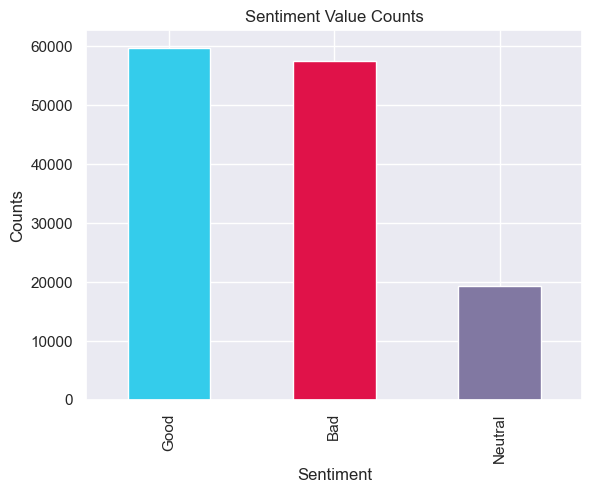

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
sns.set()
df = pd.read_csv('snaggr_file_no_priceline.csv', index_col=0)
df.dropna(inplace=True)
# Get the value counts of each sentiment
sentiment_counts = df['sentiment'].value_counts()

# Plot a bar graph
sentiment_counts.plot(kind='bar', color=['#34cceb', '#e01249', '#8178a2'])

# Add title and labels
plt.title('Sentiment Value Counts')
plt.xlabel('Sentiment')
plt.ylabel('Counts')

# Show the plot
plt.show()

# Binary Classification Model (Good or Bad)

C:\Users\deonp\AppData\Local\Temp\ipykernel_1740\3674156137.py:16: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('snaggr_file_no_priceline.csv', index_col=0)


Epoch 1/100
3938/3938 [==============================] - 279s 70ms/step - loss: 0.3561 - accuracy: 0.8628 - val_loss: 0.3110 - val_accuracy: 0.8762
Epoch 2/100
3938/3938 [==============================] - 258s 65ms/step - loss: 0.2953 - accuracy: 0.8862 - val_loss: 0.3044 - val_accuracy: 0.8821
Epoch 3/100
3938/3938 [==============================] - 254s 64ms/step - loss: 0.2778 - accuracy: 0.8937 - val_loss: 0.2939 - val_accuracy: 0.8855
Epoch 4/100
3938/3938 [==============================] - 251s 64ms/step - loss: 0.2675 - accuracy: 0.8984 - val_loss: 0.2954 - val_accuracy: 0.8863
Epoch 5/100
855/855 [==============================] - 7s 8ms/step


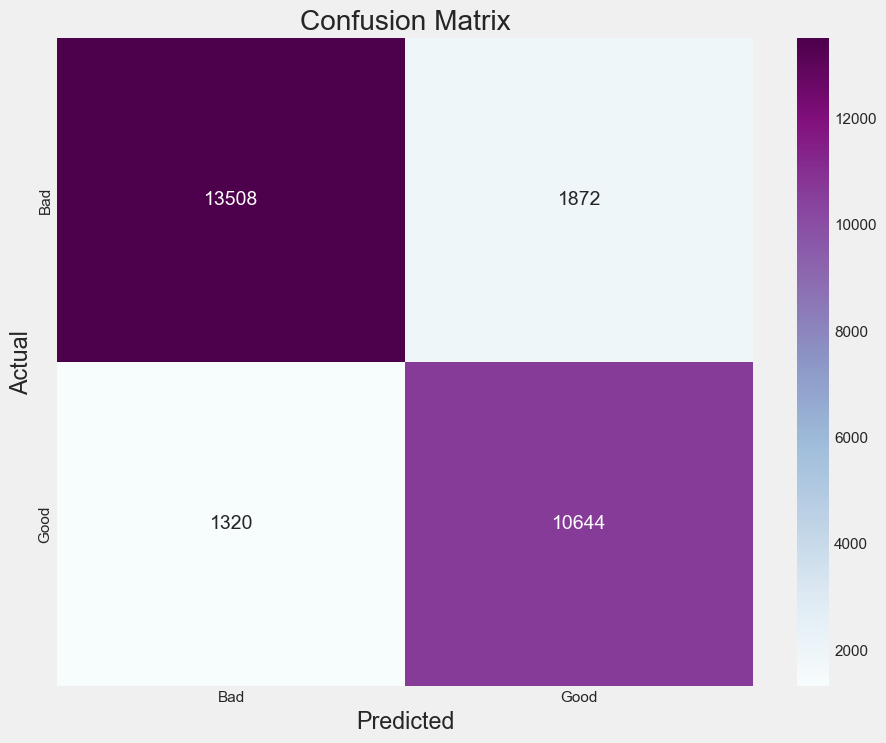

Accuracy: 0.8832650672908133
Classification Report:
               precision    recall  f1-score   support

         Bad       0.91      0.88      0.89     15380
        Good       0.85      0.89      0.87     11964

    accuracy                           0.88     27344
   macro avg       0.88      0.88      0.88     27344
weighted avg       0.88      0.88      0.88     27344



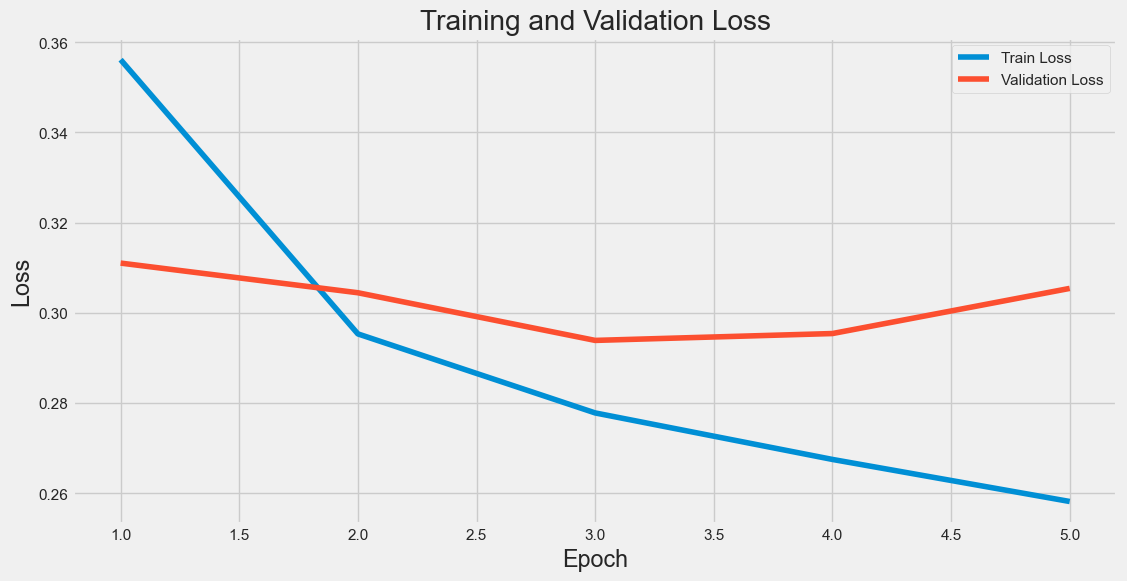

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load the data
df = pd.read_csv('snaggr_file_no_priceline.csv', index_col=0)
df.dropna(inplace=True)

# Replace 'Neutral' with 'Bad'
df.loc[df['sentiment'] == 'Neutral', 'sentiment'] = 'Bad'

# Tokenize the review texts
tokenizer = Tokenizer(num_words=5000)  # Adjust num_words based on your data
tokenizer.fit_on_texts(df['reviews'])
X = tokenizer.texts_to_sequences(df['reviews'])

# Pad the sequences
X = pad_sequences(X, maxlen=100)  # Adjust maxlen based on your data

# Encode the labels
y = pd.get_dummies(df['sentiment']).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the RNN model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, input_length=100))  # Adjust input_dim, output_dim, and input_length based on your data
model.add(LSTM(units=25, dropout=0.2, kernel_regularizer=l2(0.0001), recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(units=25, dropout=0.2, kernel_regularizer=l2(0.005), recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax', kernel_regularizer=l2(0.01)))  

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# Control when the model stops training
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Predict the sentiments for the test data
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)
# <---------------------------------------------------------END OF TRAIN/TEST CODE-------------------------------------------->



# Map the integer labels back to original string labels
label_map = {0: 'Bad', 1: 'Good'}
y_test_labels = [label_map[label] for label in y_test_classes]
y_pred_labels = [label_map[label] for label in y_pred_classes]
# Generate confusion matrix
conf_mat = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='BuPu', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Accuracy:", accuracy_score(y_test_classes, y_pred_classes))
print("Classification Report:\n", classification_report(y_test_labels, y_pred_labels))


train_loss = history.history['loss']
val_loss = history.history['val_loss'] 
loss_df = pd.DataFrame({'train_loss' : train_loss, 'val_loss' : val_loss})
epoch = range(1, len(train_loss) + 1)

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 6))

# Plot using Seaborn
sns.lineplot(data=loss_df, x=epoch, y=train_loss, label='Train Loss')
sns.lineplot(data=loss_df, x=epoch, y=val_loss, label='Validation Loss')

# Set plot title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Display the plot
plt.legend()
plt.show()

# model.save('snaggr_2class_rnn_model.h5')

In [14]:
model.save('snaggr_2class_rnn_model.h5')
joblib.dump(tokenizer, 'snaggr_tokenizer.joblib')

['snaggr_tokenizer.joblib']

## To build a good chatbot, It will be extremely useful to know what words appear most in different sentiments. I will use the wordcloud library to visualize that information.

C:\Users\deonp\AppData\Local\Temp\ipykernel_43332\719281557.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('snaggr_file_no_priceline.csv', index_col=0)


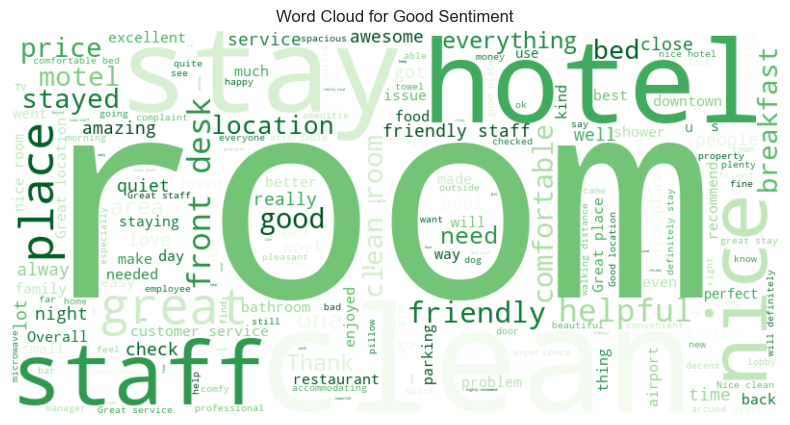

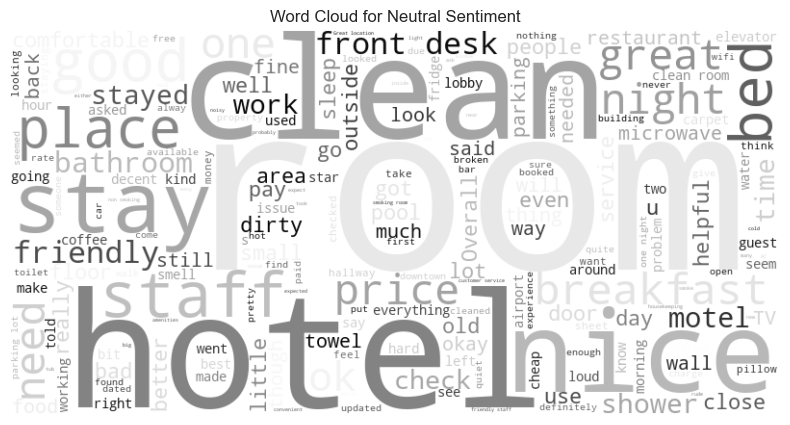

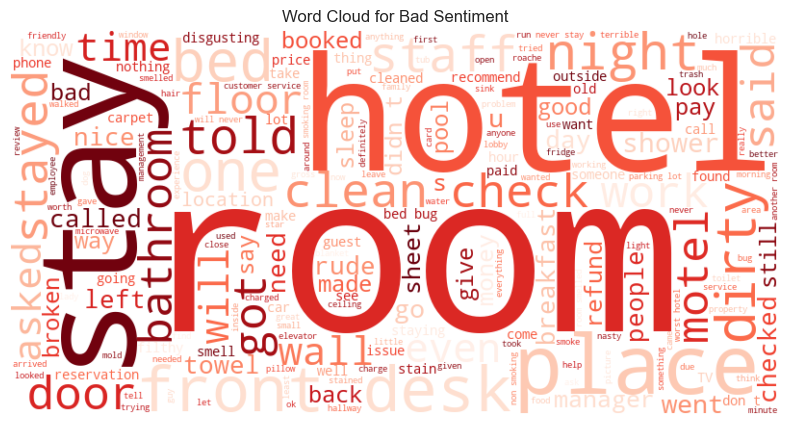

In [8]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
df = pd.read_csv('snaggr_file_no_priceline.csv', index_col=0)
df.dropna(inplace=True)
def generate_word_cloud(sentiment, color):
    text = " ".join(review for review in df[df['sentiment'] == sentiment]['reviews'])
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for {sentiment.capitalize()} Sentiment")
    plt.axis("off")
    plt.show()

# Generate word clouds for each sentiment
generate_word_cloud('Good', 'Greens')
generate_word_cloud('Neutral', 'binary')
generate_word_cloud('Bad', 'Reds_r')

## Simple Chatbot Using The Model

In [4]:
import numpy as np
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import joblib

# Load the trained model
model = load_model('snaggr_2class_rnn_model.h5')

# Load the tokenizer
tokenizer = joblib.load('snaggr_tokenizer.joblib')

def preprocess_input(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=100)
    return padded

def predict_sentiment(text):
    preprocessed = preprocess_input(text)
    prediction = model.predict(preprocessed)
    return 'Good' if prediction[0][1] > 0.5 else 'Bad'

def chatbot():
    print("Welcome to Deon's Customer Feedback Application!")
    while True:
        user_input = input("Please provide your feedback: ")
        
        if user_input.lower() == 'exit':
            print("Thank you for using our service. Goodbye!")
            break
        
        sentiment = predict_sentiment(user_input)
        
        if sentiment == 'Good':
            print("We appreciate your positive feedback. Would you be interested in becoming a member? (Yes/No)")
            response = input().lower()
            if response == 'yes':
                print("Great! You're being redirected to our Member Sign-up Page.")
            else:
                print("No problem! Is there anything else I can help you with?")
        else:
            print("We're sorry you had a bad experience. In just a few words, could you explain the issue?")
            issue = input().lower()
            if 'room' in issue:
                print("I apologize for the issues with your room. We'll look into it immediately.")
            elif 'staff' or 'employees' or 'workers' in issue:
                print("I'm sorry about your experience with our staff. We'll address this with our team.")
            elif 'pool' in issue:
                print("We apologize for any problems you encountered with our pool. We'll look into this issue immediately.")
            elif 'breakfast' or 'food' in issue:
                print('We regret that our food service did not meet your expectations. We will work on improving our food services.')
            else:
                print("We're sorry for your negative experience. We'll do our best to address the issue.")

        print("\nIs there anything else you'd like to share? (Type 'exit' to end the conversation)")

if __name__ == "__main__":
    chatbot()

Welcome to Deon's Customer Feedback Application!
Please provide your feedback: This was one of the worst hotels I've ever stayed at!
1/1 [==============================] - 0s 354ms/step
We're sorry you had a bad experience. In just a few words, could you explain the issue?
Your workers are very rude!
I'm sorry about your experience with our staff. We'll address this with our team.

Is there anything else you'd like to share? (Type 'exit' to end the conversation)
Please provide your feedback: exit
Thank you for using our service. Goodbye!


## Future improvements can be implemented by utilizing insights gained from the wordcloud visualizations to create more elaborate responses for common complaints.